# Use Seq2Seq Model to Predict the Calibrations (Multiple Xtals)
## Settings:
+ **Input**: the previous calibrations and luminosity;
+ **Output**: the future calibrations;
+ **Training data**: the data collected from the crystal 54,000 in the year of 2016.

## Two Cases:
1. **Case1**: We **do not** reuse the predicted values. For example, we **do not** use the predicted values at *t* to predict the *t+1* values. 
2. **Case2**: We **do** reuse the predicted values. For example, we **do** use the predicted values at *t* to predict the *t+1* values. 

## Main:
This is the main function/entry for our Seq2Seq model. The training can be performed on multiple crystals

### Import packages/classes.
+ **seq2seq_model** defines the model;
+ **seq2seq_train** defines the training procedures;
+ **seq2seq_prediction** defines the prediction procedures;
+ **ecal_dataset_prep** defines the data preprocessing procedures.

In [1]:
#------ import packages ------#
from seq2seq_model import *
from seq2seq_train import *
from seq2seq_prediction import *
from ecal_dataset_prep import *

### Set up the hyper-parameters.
+ **input_len**: the time steps (sequence length) for input data;
+ **output_len**: the time steps (sequence length) for output data;
+ **stride**: the stide of the sequence/window (default: output_len);
+ **learning_rate**: the learning rate for our model;
+ **n_epochs**: the maximum epoch to train our model;
+ **print_step**: we print the training information per "print_step" epoch;
+ **batch_size**: the batch size to train our model;
+ **opt_alg**: the name of the optimization function (one should select one from {adam', 'sgd'});
+ **train_strategy**: different training strategies (one should select one from {'recursive', 'teacher_forcing', 'mixed'});
+ **teacher_forcing_ratio**: it is a float number in the range of 0-1; it will be ignored when train_strategy='recursive';
+ **hidden_size**: the number of features in the hidden state;
+ **num_layers**: the number of recurrent layers;
+ **gpu_id**: the gpu id;
+ **train_file**: the training csv file;
+ **val_file**: the validation csv file;
+ **test_file**: the test csv file;
+ **crystal_id**: the crystal's id;
+ **verbose**:set it to be True if print information is desired; otherwise, set it to False; default (False).

In [2]:
input_len = 24
output_len = 24
stride = output_len
learning_rate = 1e-3
n_epochs = 20
print_step = 1
batch_size = 128
if output_len>=48: batch_size = 32
opt_alg = 'adam'
train_strategy = 'teacher_forcing' #"Please select one of them---[recursive, teacher_forcing, mixed]!"
teacher_forcing_ratio = 0.5 # please set it in the range of [0,1]
hidden_size = 1024
num_layers = 2
gpu_id = 0
crystal_id_start = 54000
crystal_id_end = 54005 # model trained on crystals from crystal_id_start to crystal_id_end
verbose = False
plt_show = False
training_year = 2016 # model trained on this year [2016,2017]
device = torch.device("cuda:{}".format(gpu_id) if torch.cuda.is_available() else "cpu")
folder_name = 'LSTM_{}_IW_{}_OW_{}_LR_{}_ID_{}_{}_train_year_{}'.format(hidden_size, input_len, output_len, learning_rate,crystal_id_start,crystal_id_end,training_year)


### Create folders to keep the results

In [3]:
# folder to save figures
save_dir_vis_data = '{}/vis_data/'.format(folder_name)

# folder to save models
save_dir_models = '{}/models/'.format(folder_name)

# folders for case1
save_dir_case1_fig= '{}/case1_fig/'.format(folder_name)
save_dir_case1_csv= '{}/case1_csv/'.format(folder_name)

# folders for case2
save_dir_case2_fig= '{}/case2_fig/'.format(folder_name)
save_dir_case2_csv= '{}/case2_csv/'.format(folder_name)

dir_list = [save_dir_vis_data, save_dir_case1_fig, save_dir_case1_csv, save_dir_case2_fig, save_dir_case2_csv,save_dir_models]
for cur_dir in dir_list:
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)
        print('>>> {} has been created successfully!'.format(cur_dir))
    else:
        print('>>> {} is exist!'.format(cur_dir))

>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000_54005_train_year_2016/vis_data/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000_54005_train_year_2016/case1_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000_54005_train_year_2016/case1_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000_54005_train_year_2016/case2_fig/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000_54005_train_year_2016/case2_csv/ is exist!
>>> LSTM_1024_IW_24_OW_24_LR_0.001_ID_54000_54005_train_year_2016/models/ is exist!


### Normalize the datasets.

In [4]:
# for train_file_2016/2017

X_train_all = None
Y_train_all = None

for crystal_id in range(crystal_id_start,crystal_id_end+1):
    try:
        fig_name_cali = os.path.join(save_dir_vis_data, '{}_cali_original_ID_{}.png'.format(training_year,crystal_id))
        fig_name_scaled_cali = os.path.join(save_dir_vis_data, '{}_cali_scaled_ID_{}.png'.format(training_year,crystal_id))
        train_file_2016 = '../../data/interim/df_skimmed_xtal_{}_2016.csv'.format(crystal_id)
        test_file_2017 = '../../data/interim/df_skimmed_xtal_{}_2017.csv'.format(crystal_id)
        test_file_2018 = '../../data/interim/df_skimmed_xtal_{}_2018.csv'.format(crystal_id)


        if training_year == 2016:
            ecal_dataset_prep_train_2016 = ECAL_Dataset_Prep(train_file_2016, 
                                                            input_len, 
                                                            output_len, 
                                                            stride, 
                                                            fig_name_cali, 
                                                            fig_name_scaled_cali,
                                                            verbose,
                                                            plt_show)
            ecal_dataset_prep_train_2016.start_processing()

            X_train = ecal_dataset_prep_train_2016.torch_X
            Y_train = ecal_dataset_prep_train_2016.torch_Y
        elif training_year == 2017:
            ecal_dataset_prep_train_2017 = ECAL_Dataset_Prep(test_file_2017, 
                                                            input_len, 
                                                            output_len, 
                                                            stride, 
                                                            fig_name_cali, 
                                                            fig_name_scaled_cali,
                                                            verbose,
                                                            plt_show)
            ecal_dataset_prep_train_2017.start_processing()

            X_train = ecal_dataset_prep_train_2017.torch_X
            Y_train = ecal_dataset_prep_train_2017.torch_Y
        else:
            print("please use 2016 or 2017 to train the model")

        if X_train_all == None:
            X_train_all = X_train
            Y_train_all = Y_train
        else:
            X_train_all = torch.cat( (X_train_all,X_train), dim=1 )
            Y_train_all = torch.cat( (Y_train_all,Y_train), dim=1 )
    except Exception as e:
        print("skip ID {}".format(crystal_id))

### Create Seq2Seq model including an EncoderNet and a DecoderNet

In [5]:
lstm_encoder = LSTM_Encoder(input_size=X_train_all.shape[2], hidden_size=hidden_size, num_layers=num_layers)
lstm_decoder = LSTM_Decoder(input_size=Y_train_all.shape[2], hidden_size=hidden_size, num_layers=num_layers)
lstm_encoder.to(device)
lstm_decoder.to(device)
print(lstm_encoder)
print(lstm_decoder)

LSTM_Encoder(
  (lstm): LSTM(2, 1024, num_layers=2)
)
LSTM_Decoder(
  (lstm): LSTM(2, 1024, num_layers=2)
  (linear): Linear(in_features=1024, out_features=1, bias=True)
)


### Training Seq2Seq model

>>> Start training... (be patient: training time varies)
======== epoch 0 out of 20 epochs ========
batch 0 out of 10 batches
batch 1 out of 10 batches
batch 2 out of 10 batches
batch 3 out of 10 batches
batch 4 out of 10 batches
batch 5 out of 10 batches
batch 6 out of 10 batches
batch 7 out of 10 batches
batch 8 out of 10 batches
batch 9 out of 10 batches
======== epoch 1 out of 20 epochs ========
batch 0 out of 10 batches
batch 1 out of 10 batches
batch 2 out of 10 batches
batch 3 out of 10 batches
batch 4 out of 10 batches
batch 5 out of 10 batches
batch 6 out of 10 batches
batch 7 out of 10 batches
batch 8 out of 10 batches
batch 9 out of 10 batches
======== epoch 2 out of 20 epochs ========
batch 0 out of 10 batches
batch 1 out of 10 batches
batch 2 out of 10 batches
batch 3 out of 10 batches
batch 4 out of 10 batches
batch 5 out of 10 batches
batch 6 out of 10 batches
batch 7 out of 10 batches
batch 8 out of 10 batches
batch 9 out of 10 batches
======== epoch 3 out of 20 epochs 

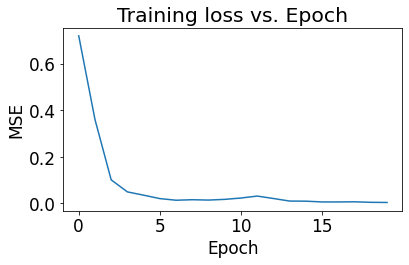

>>> Finish training!


In [6]:
loss_figure_name = os.path.join(save_dir_vis_data, '0_loss.png')
target_len = output_len
seq2sqe_train = Seq2Seq_Train(lstm_encoder,
                              lstm_decoder,
                              X_train_all,
                              Y_train_all,
                              n_epochs,
                              target_len,
                              batch_size,
                              learning_rate,
                              opt_alg,
                              print_step,
                              train_strategy,
                              teacher_forcing_ratio,
                              device,
                              loss_figure_name,
                              verbose=True,
                              plt_show=True)
seq2sqe_train.start_train()

### Save trained models

In [7]:
#after training, we also want to save our models
model_file_name = os.path.join(save_dir_models, 'lstm_encoder.pt')
save_model(lstm_encoder.eval(), model_file_name)
model_file_name = os.path.join(save_dir_models, 'lstm_decoder.pt')
save_model(lstm_decoder.eval(), model_file_name)

The trained model has been saved!
The trained model has been saved!


### Case1 Prediction:  do not use predictions as input to help the next-round prediction

In [8]:
MAPE_dict = {}
for test_case in ['case1']:
    for year in ['2017']:
        MAPE_key = test_case + year
        MAPE_dict[MAPE_key] = -1
        MAPEs = []
        lengths = []
        for crystal_id in range(crystal_id_start,crystal_id_end+1):
        
            try:
                print("{}_year_{}_ID_{}".format(test_case,year,crystal_id))
                # for test_file_201X
                fig_name_cali = os.path.join(save_dir_vis_data, '{}_cali_original_ID_{}.png'.format(year,crystal_id))
                fig_name_scaled_cali = os.path.join(save_dir_vis_data, '{}_cali_scaled_ID_{}.png'.format(year,crystal_id))

                test_file_201X = '../../data/interim/df_skimmed_xtal_{}_{}.csv'.format(crystal_id,year)

                ecal_dataset_prep_test_201X = ECAL_Dataset_Prep(test_file_201X, 
                                                                input_len, 
                                                                output_len, 
                                                                stride, 
                                                                fig_name_cali, 
                                                                fig_name_scaled_cali,
                                                                verbose,
                                                                plt_show=False)
                ecal_dataset_prep_test_201X.start_processing()


                # check its prediction on test data-201X
                # Please note that here, the data are in the numpy format, not the tensor format
                Xtrain = ecal_dataset_prep_test_201X.np_X
                Ytrain = ecal_dataset_prep_test_201X.np_Y
                df = ecal_dataset_prep_test_201X.df_lumi
                scaler_cali = ecal_dataset_prep_test_201X.scaler_cali
                
                
                fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}_ID_{}.png'.format(test_case,year,crystal_id))
                fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}_ID_{}.png'.format(test_case,year,crystal_id))
                metric_file = os.path.join(save_dir_case1_csv, '{}_{}_ID_{}.csv'.format(test_case,year,crystal_id))

                seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                                        lstm_decoder,
                                                        Xtrain,
                                                        Ytrain,
                                                        df,
                                                        scaler_cali,
                                                        device,
                                                        fig_name_mape,
                                                        fig_name_mse,
                                                        metric_file,
                                                        test_case,
                                                       plt_show=False)
                seq2seq_prediction.start_prediction()
                [MAPE,length] = seq2seq_prediction.getAPE()
                print("MAPE = {}, length = {}".format(MAPE,length))
                MAPEs.append(MAPE)
                lengths.append(length)

                del seq2seq_prediction
                del ecal_dataset_prep_test_201X

        

            except Exception as e:
                print("skip ID {}".format(crystal_id))

        MAPE_vec = np.array(MAPEs)
        lengths_vec = np.array(lengths)
        final_MAPE = MAPE_vec@lengths_vec/np.sum(lengths_vec)
        print("==============================================================")
        print("{}_year_{}: final MAPE = {}".format(test_case,year,final_MAPE))
        print("==============================================================")
        MAPE_dict[MAPE_key] = final_MAPE

case1_year_2017_ID_54000
>>>  case1 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.162, length = 5520
case1_year_2017_ID_54001
>>>  case1 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.198, length = 5520
case1_year_2017_ID_54002
>>>  case1 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.142, length = 5520
case1_year_2017_ID_54003
>>>  case1 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.285, length = 5520
case1_year_2017_ID_54004
>>>  case1 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.227, length = 5520
case1_year_2017_ID_54005
>>>  case1 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.191, length = 5520
case1_year_2017: final MAPE = 0.2008333333333333


### Case2 Prediction: use predictions as input to help the next-round prediction.

In [9]:
MAPE_dict = {}
for test_case in ['case2']:
    for year in ['2017']:
        MAPE_key = test_case + year
        MAPE_dict[MAPE_key] = -1
        MAPEs = []
        lengths = []
        for crystal_id in range(crystal_id_start,crystal_id_end+1):
        
            try:
                print("{}_year_{}_ID_{}".format(test_case,year,crystal_id))
                # for test_file_201X
                fig_name_cali = os.path.join(save_dir_vis_data, '{}_cali_original_ID_{}.png'.format(year,crystal_id))
                fig_name_scaled_cali = os.path.join(save_dir_vis_data, '{}_cali_scaled_ID_{}.png'.format(year,crystal_id))

                test_file_201X = '../../data/interim/df_skimmed_xtal_{}_{}.csv'.format(crystal_id,year)

                ecal_dataset_prep_test_201X = ECAL_Dataset_Prep(test_file_201X, 
                                                                input_len, 
                                                                output_len, 
                                                                stride, 
                                                                fig_name_cali, 
                                                                fig_name_scaled_cali,
                                                                verbose,
                                                                plt_show=False)
                ecal_dataset_prep_test_201X.start_processing()


                # check its prediction on test data-201X
                # Please note that here, the data are in the numpy format, not the tensor format
                Xtrain = ecal_dataset_prep_test_201X.np_X
                Ytrain = ecal_dataset_prep_test_201X.np_Y
                df = ecal_dataset_prep_test_201X.df_lumi
                scaler_cali = ecal_dataset_prep_test_201X.scaler_cali
                
                
                fig_name_mape = os.path.join(save_dir_case1_fig, '0_MAPE_{}_{}_ID_{}.png'.format(test_case,year,crystal_id))
                fig_name_mse = os.path.join(save_dir_case1_fig, '1_MSE_{}_{}_ID_{}.png'.format(test_case,year,crystal_id))
                metric_file = os.path.join(save_dir_case1_csv, '{}_{}_ID_{}.csv'.format(test_case,year,crystal_id))

                seq2seq_prediction = Seq2Seq_Prediction(lstm_encoder,
                                                        lstm_decoder,
                                                        Xtrain,
                                                        Ytrain,
                                                        df,
                                                        scaler_cali,
                                                        device,
                                                        fig_name_mape,
                                                        fig_name_mse,
                                                        metric_file,
                                                        test_case,
                                                       plt_show=False)
                seq2seq_prediction.start_prediction()
                [MAPE,length] = seq2seq_prediction.getAPE()
                print("MAPE = {}, length = {}".format(MAPE,length))
                MAPEs.append(MAPE)
                lengths.append(length)

                del seq2seq_prediction
                del ecal_dataset_prep_test_201X

        

            except Exception as e:
                print("skip ID {}".format(crystal_id))

        MAPE_vec = np.array(MAPEs)
        lengths_vec = np.array(lengths)
        final_MAPE = MAPE_vec@lengths_vec/np.sum(lengths_vec)
        print("==============================================================")
        print("{}_year_{}: final MAPE = {}".format(test_case,year,final_MAPE))
        print("==============================================================")
        MAPE_dict[MAPE_key] = final_MAPE

case2_year_2017_ID_54000
>>>  case2 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.327, length = 5520
case2_year_2017_ID_54001
>>>  case2 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.421, length = 5520
case2_year_2017_ID_54002
>>>  case2 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.293, length = 5520
case2_year_2017_ID_54003
>>>  case2 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.725, length = 5520
case2_year_2017_ID_54004
>>>  case2 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.559, length = 5520
case2_year_2017_ID_54005
>>>  case2 : start prediction...(be patient)
>>> Finish prediction!
MAPE = 0.382, length = 5520
case2_year_2017: final MAPE = 0.45116666666666666
